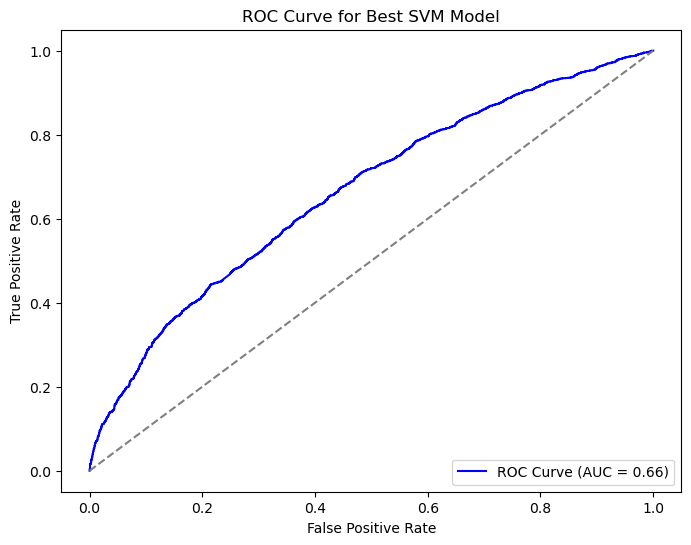

Confusion Matrix:
                   No Readmit (Pred)  Readmit (Pred)
No Readmit (True)               2096             562
Readmit (True)                  1322            1020

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.79      0.69      2658
           1       0.64      0.44      0.52      2342

    accuracy                           0.62      5000
   macro avg       0.63      0.61      0.60      5000
weighted avg       0.63      0.62      0.61      5000

Ranked Results Based on Mean Test Score:
    rank_test_score  mean_test_score param_C param_gamma param_class_weight
15                1         0.654827      10       scale           balanced
12                2         0.653332      10       scale               None
6                 3         0.650453       1       scale               None
9                 4         0.643336       1       scale           balanced
7                 5         0.617341       1       

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, make_scorer, auc
import matplotlib.pyplot as plt

# Load the data (replace with actual file path if needed)
data = pd.read_csv('hospital_readmissions.csv')
data['severity'] = data['time_in_hospital'] * (data['n_lab_procedures'] + 32 * data['n_procedures'])
data['log_time_in_hospital'] = np.log1p(data['time_in_hospital'])
data['log_n_procedures'] = np.log1p(data['n_procedures'])
data['log_n_inpatient'] = np.log1p(data['n_inpatient'])
data['log_severity'] = np.log1p(data['severity'])
data = data.drop(['time_in_hospital', 'n_procedures', 'n_inpatient', 'severity'], axis=1)

# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, columns=[
    'age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med'
], drop_first=True)

# Map target column "readmitted" to binary values
data_encoded['readmitted'] = data_encoded['readmitted'].map({'no': 0, 'yes': 1})

# Define features (X) and target (y)
X = data_encoded.drop('readmitted', axis=1)
y = data_encoded['readmitted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=10)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up hyperparameter grid for SVM with RBF kernel
param_grid = {
    'C': [0.1, 1, 10],     # Regularization strength
    'gamma': ['scale', 0.1, 1],  # Kernel coefficient
    'class_weight': [None, 'balanced']  # To handle imbalance
}

# Initialize SVM model
svm_model = SVC(kernel='rbf', probability=True)

# Run GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, scoring=scorer, cv=cv, n_jobs=-1, refit=True)
grid_search.fit(X, y)

# Collect best parameters and best scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display top ranks based on mean test score
ranked_results = cv_results[['rank_test_score', 'mean_test_score', 'param_C', 'param_gamma', 'param_class_weight']]
ranked_results = ranked_results.sort_values(by='rank_test_score').head()

# Evaluate performance across CV folds
train_auc_scores, val_auc_scores = [], []
for train_idx, val_idx in cv.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    model = SVC(**best_params, kernel='rbf', probability=True)
    model.fit(X_train_cv, y_train_cv)
    train_auc_scores.append(roc_auc_score(y_train_cv, model.predict_proba(X_train_cv)[:, 1]))
    val_auc_scores.append(roc_auc_score(y_val_cv, model.predict_proba(X_val_cv)[:, 1]))

# Display AUC table
auc_table = pd.DataFrame({
    'Train AUC (CV)': train_auc_scores,
    'Validation AUC (CV)': val_auc_scores
})
auc_table.loc['Mean'] = auc_table.mean()

# Train best model and evaluate on test data
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best SVM Model')
plt.legend(loc="lower right")
plt.show()

# Display confusion matrix and classification report
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(pd.DataFrame(conf_matrix, index=['No Readmit (True)', 'Readmit (True)'], columns=['No Readmit (Pred)', 'Readmit (Pred)']))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display results
print("Ranked Results Based on Mean Test Score:")
print(ranked_results)
print("\nTrain and Validation AUC Scores Across Cross-Validation Folds:")
print(auc_table)


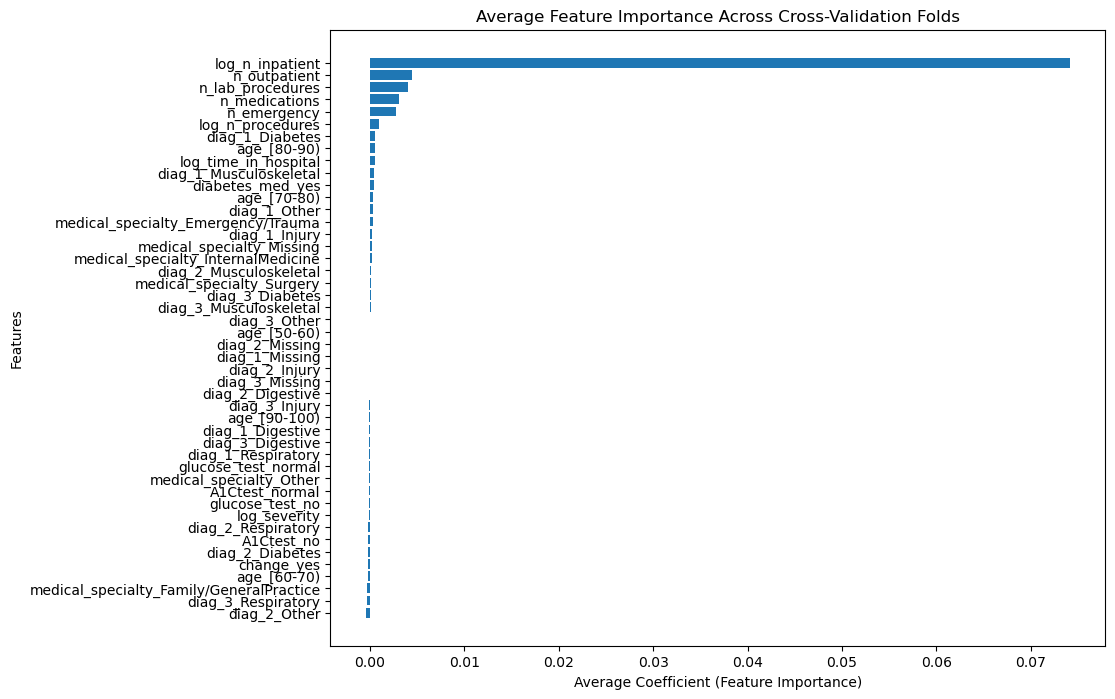

In [3]:
from sklearn.inspection import permutation_importance

# Define StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=10)

# Collect average feature importances across cross-validation folds
feature_importance_means = []

for train_idx, val_idx in cv.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    
    model = SVC(**best_params, kernel='rbf', probability=True)
    model.fit(X_train_cv, y_train_cv)
    
    # Use permutation importance to estimate feature importances
    result = permutation_importance(model, X_val_cv, y_val_cv, n_repeats=10, random_state=42, n_jobs=-1)
    feature_importance_means.append(result.importances_mean)

# Calculate average feature importance across all CV folds
average_importance = np.mean(feature_importance_means, axis=0)

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Importance': average_importance
}).sort_values(by='Average Importance', ascending=False)

# Plot the average feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Average Importance'])
plt.xlabel('Average Coefficient (Feature Importance)')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Cross-Validation Folds')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()
